In [85]:
import numpy as np
import pandas as pd

import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
import re

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [86]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [87]:
df = pd.read_csv('/content/drive/MyDrive/DA20 - Final Project/Supervised Learning/both_urls_dataset.csv')
df.head()

,url,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,...,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,status
0,http://www.crestonwood.com/router.php,37,19,0,3,0,0,0,0,0,...,0,1,0,45,-1,0,1,1,4,legitimate
1,http://shadetreetechnology.com/V4/validation/a...,77,23,1,1,0,0,0,0,0,...,1,0,0,77,5767,0,0,1,2,phishing
2,https://support-appleld.com.secureupdate.duila...,126,50,1,4,1,0,1,2,0,...,1,0,0,14,4004,5828815,0,1,0,phishing
3,http://rgipt.ac.in,18,11,0,2,0,0,0,0,0,...,1,0,0,62,-1,107721,0,0,3,legitimate
4,http://www.iracing.com/tracks/gateway-motorspo...,55,15,0,2,2,0,0,0,0,...,0,1,0,224,8175,8725,0,0,6,legitimate


In [88]:
df.corr()

<ipython-input-88-2f6f6606aa2c>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()


,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,nb_eq,...,empty_title,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank
length_url,1.000000,0.223025,0.453961,0.443589,0.399564,0.150739,0.520930,0.576268,NaN,0.621745,...,0.041879,0.125159,-0.006476,-0.007082,0.002799,-0.006798,0.072205,0.023357,0.236395,-0.102582
length_hostname,0.223025,1.000000,0.252013,0.408956,0.057702,0.071793,0.162400,0.145617,NaN,0.183405,...,-0.015054,0.217284,0.074707,-0.097794,-0.041081,0.013854,0.163238,-0.023344,0.213990,-0.159342
ip,0.453961,0.252013,1.000000,0.288398,0.109860,0.059401,0.405434,0.383262,NaN,0.440972,...,0.037971,0.137716,0.014561,0.053246,-0.108869,-0.077020,0.167930,0.127823,0.270743,-0.218968
nb_dots,0.443589,0.408956,0.288398,1.000000,0.045099,0.263283,0.347411,0.435798,NaN,0.414902,...,0.040875,0.107789,0.055560,0.056407,-0.024117,-0.007818,0.087969,0.126659,0.209616,-0.097312
nb_hyphens,0.399564,0.057702,0.109860,0.045099,1.000000,0.018770,0.036804,0.120487,NaN,0.107050,...,-0.033302,0.006909,0.020297,-0.055794,0.038163,0.080104,-0.041464,-0.031477,-0.018828,0.104341
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
domain_age,-0.006798,0.013854,-0.077020,-0.007818,0.080104,-0.067334,-0.045623,-0.043933,NaN,-0.039726,...,-0.069671,-0.174976,0.051116,-0.275520,0.269109,1.000000,-0.096698,-0.068023,-0.210111,0.589602
web_traffic,0.072205,0.163238,0.167930,0.087969,-0.041464,-0.009459,0.143777,0.164797,NaN,0.187809,...,-0.030888,0.081786,0.083888,0.022598,-0.110435,-0.096698,1.000000,-0.007113,0.034099,-0.209526
dns_record,0.023357,-0.023344,0.127823,0.126659,-0.031477,0.031611,0.009441,0.076372,NaN,0.052159,...,0.006232,0.062084,0.043817,0.213899,-0.060811,-0.068023,-0.007113,1.000000,0.096413,-0.142135
google_index,0.236395,0.213990,0.270743,0.209616,-0.018828,0.113217,0.201260,0.129093,NaN,0.167385,...,0.208367,0.267465,-0.143655,0.040633,-0.134656,-0.210111,0.034099,0.096413,1.000000,-0.389887


In [89]:
df.isnull().sum()

url                0
length_url         0
length_hostname    0
ip                 0
nb_dots            0
                  ..
web_traffic        0
dns_record         0
google_index       0
page_rank          0
status             0
Length: 89, dtype: int64

In [90]:
# Data selection
feature_df = df['url']
phishing_df = df['status']

# Transform data
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder

# Vectorize URLs
vectorizer = CountVectorizer()
feature_vec = vectorizer.fit_transform(feature_df)

# Encode status column (legitimate=0, phishing=1)
label_encoder = LabelEncoder()
phishing_arr = label_encoder.fit_transform(phishing_df)

phishing_arr

array([0, 1, 1, ..., 0, 0, 1])

In [91]:
#chia tap train, test
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(feature_vec, phishing_arr, test_size=0.25, random_state=0)

print('Train: ', x_train.shape[0])
print('Test: ', x_test.shape[0])

Train:  8572
Test:  2858


In [92]:
#modeling lbfgs
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(solver='lbfgs', max_iter=5000)
lr_lbfgs = logreg.fit(x_train,y_train)

In [93]:
y_pred_lbfgs=logreg.predict(x_test)
print(y_pred_lbfgs)

[0 1 1 ... 0 0 0]


In [94]:
from sklearn.metrics import jaccard_score
print('lbfgs:', jaccard_score(y_test, y_pred_lbfgs,pos_label=0))

lbfgs: 0.8261146496815287


In [102]:
logreg.score(x_test, y_test)

0.9044786564030791

In [103]:
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred_lbfgs)
cnf_matrix

array([[1297,  133],
       [ 140, 1288]])

Text(0.5, 427.9555555555555, 'Predicted label')

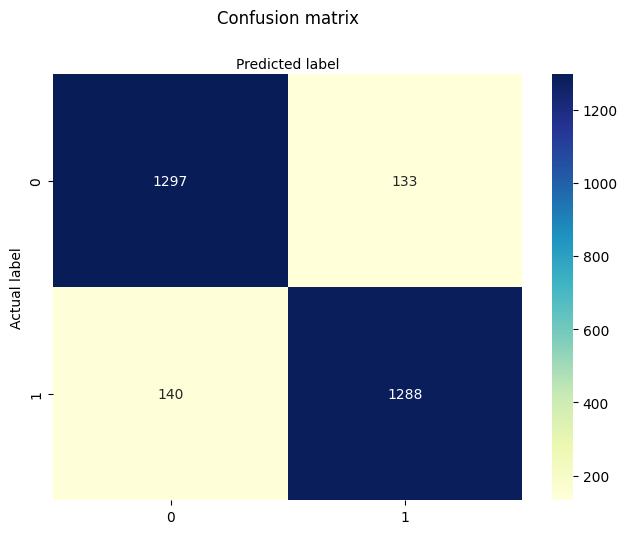

In [104]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
class_names=[] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [128]:
new_url = input('Enter an URL to test: ')

# Transform features into same format as training data
new_vector = vectorizer.transform([new_url])

# Make prediction using trained model
prediction = logreg.predict(new_vector)

if prediction[0] == 0:
  print('Legitimate')
else:
  print('Phishing')


Enter an URL to test: https://github.com/buisonanh?tab=repositories
Legitimate
